### Train GP emulator for PFT mean LAI max
##### Linnia Hawkins 9-11-2023
##### updated by Katie Dagon 10-24-2023

In [9]:
#import warnings
#warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import gpflow
#import tensorflow as tf
#from esem.utils import get_random_params

from sklearn import preprocessing

In [ ]:
### import some analysis functions we wrote for this project
#import sys ; sys.path.append("../") ; sys.path.append("../../") ;
#from ppe_analysis.analysis import *
#from emulation_pyfunctions import *
#from pyfunctions import *

### Load LHC CLM-PPE (PFT mean annual max LAI)

In [2]:
# set PFT index
p = 1 # 1=needleleaf evergreen tree

In [3]:
#Load PPE
#LHC_pmean=xr.open_dataset('/glade/u/home/linnia/clm5ppe/pyth/exp2_PFT/processed_data/LHC_pmean(TLAImax).nc')
LHC_pmean=xr.open_dataset('./exp2_PFT/processed_data/LHC_pmean(TLAImax).nc')
NL_LAI_PPE = LHC_pmean['TLAI_pftavg_annMax_2003-2014'].sel(pft=p)

In [4]:
NL_LAI_PPE

<xarray.DataArray 'TLAI_pftavg_annMax_2003-2014' (ens: 501)>
[501 values with dtype=float64]
Coordinates:
    pft      float64 1.0
Dimensions without coordinates: ens
Attributes:
    long_name:  PFT average LAImax 2003
    units:      m^2/m^2
    years:      2003-2014

In [5]:
# load parameter sets 
#lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
lhckey = './processed_data/lhc220926.txt'
df = pd.read_csv(lhckey)
params = df.drop(columns='member')
nparams = len(params.columns)

In [6]:
params

,FUN_fracfixers,KCN,a_fix,crit_dayl,d_max,fff,froot_leaf,fstor2tran,grperc,jmaxb0,...,psi50,q10_mr,slatop,soilpsi_off,stem_leaf,sucsat_sf,theta_cj,tpu25ratio,tpuse_sf,wc2wjb0
0,0.778311,0.358026,0.255021,0.401235,0.797847,0.130074,0.938827,0.378388,0.196517,0.624727,...,0.196154,0.275884,0.762778,0.137397,0.113845,0.798198,0.036459,0.393617,0.078962,0.684588
1,0.319329,0.548803,0.630191,0.270024,0.536119,0.679190,0.672215,0.956630,0.934241,0.627186,...,0.816009,0.949813,0.717381,0.743697,0.127340,0.394660,0.093740,0.041084,0.275619,0.878455
2,0.876772,0.210794,0.662125,0.353350,0.140861,0.342557,0.275203,0.747737,0.823775,0.891879,...,0.995087,0.322946,0.474743,0.805385,0.249964,0.168115,0.282747,0.819746,0.840143,0.951915
3,0.412051,0.678111,0.398648,0.330947,0.326188,0.210967,0.327117,0.645703,0.777746,0.897482,...,0.328198,0.042303,0.766334,0.354093,0.916163,0.138359,0.635655,0.448417,0.342799,0.989434
4,0.045135,0.770734,0.298738,0.343413,0.747099,0.207547,0.488125,0.686079,0.459411,0.009303,...,0.602910,0.267256,0.176784,0.507355,0.646416,0.828712,0.466185,0.470941,0.357750,0.909412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.936317,0.335675,0.821711,0.767823,0.330586,0.745789,0.127834,0.424287,0.609700,0.286311,...,0.246081,0.700532,0.681519,0.206475,0.802992,0.453735,0.624163,0.206822,0.441036,0.411448
496,0.955479,0.845082,0.019274,0.324838,0.113533,0.540953,0.150098,0.011721,0.227892,0.006216,...,0.910214,0.993029,0.930575,0.653339,0.750147,0.475151,0.536766,0.994792,0.512649,0.000159
497,0.185969,0.996422,0.422209,0.365048,0.275200,0.320546,0.991583,0.543024,0.037573,0.802632,...,0.346204,0.008894,0.606076,0.406761,0.453041,0.047361,0.765972,0.242643,0.842275,0.731144
498,0.262130,0.912280,0.533934,0.997431,0.907613,0.991805,0.363534,0.886880,0.763445,0.192524,...,0.805913,0.401231,0.865736,0.573305,0.332778,0.352641,0.842942,0.715950,0.353015,0.358052


In [7]:
nparams

32

In [ ]:
# load parameter sets (netcdf version)
#lhckey = xr.open_dataarray('./processed_data/lhc220926.nc')
#params = lhckey.to_numpy().T
#nparams = params.shape[1]

### Load Observational Target data

In [ ]:
#calculate SP LAI, by pft
dsp=xr.open_dataset('/glade/work/linnia/LAI_SP_ctsm51d115/run/LAI_SP_ctsm51d115.clm2.h1.2000-02-01-00000.nc')
#dsp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h1.2000-02-01-00000.nc')
dsp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')
sg=xr.open_dataset('clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc')
la=sg.landfrac*sg.area

lai_sp=amax(dsp.TLAI).sel(year=2000)
w=dsp.pfts1d_wtgcell
laig=pftgrid(lai_sp,dsp)
wg=pftgrid(w,dsp)
cf=1/(wg*la).sum(dim=['lat','lon'])
laisp=cf*(laig*wg*la).sum(dim=['lat','lon']).sel(pft=range(0,16)).compute()

In [ ]:
# Observational target
NL_LAI_obs = laisp[p]

### Train PFT emulators

In [8]:
# Define kernels
kernel_linear = gpflow.kernels.Linear(active_dims=range(nparams),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(nparams), variance=1, lengthscales = np.tile(1,32))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(nparams), lengthscales=np.tile(1,nparams))

# select the kernal to use
kernel = kernel_linear + kernel_matern32 + kernel_RBF

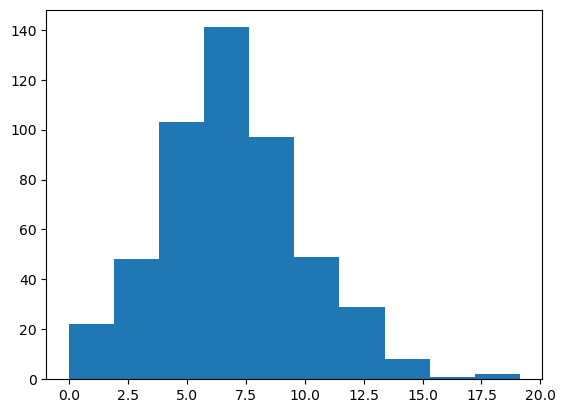

In [10]:
ntest = 50
data = NL_LAI_PPE[1:]
plt.hist(data);

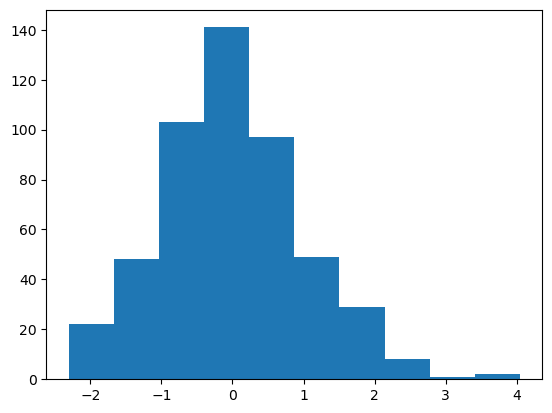

In [11]:
Y = preprocessing.scale(data)
plt.hist(Y);

In [12]:
params.shape

(500, 32)

In [13]:
Y.shape

(500,)

In [14]:
# split training and testing data
X_test, X_train = params[:ntest], params[ntest:]
y_test, y_train = Y[:ntest], Y[ntest:]

In [15]:
X_train.shape

(450, 32)

In [16]:
X_test.shape

(50, 32)

In [26]:
X_test.values

array([[0.77831114, 0.35802577, 0.25502127, ..., 0.39361723, 0.07896155,
        0.68458797],
       [0.31932864, 0.54880317, 0.63019079, ..., 0.04108439, 0.27561916,
        0.87845469],
       [0.87677181, 0.21079367, 0.6621252 , ..., 0.81974643, 0.84014328,
        0.95191497],
       ...,
       [0.58229602, 0.21377433, 0.75873718, ..., 0.06865076, 0.91264871,
        0.61636639],
       [0.78861777, 0.50679844, 0.82298078, ..., 0.7295324 , 0.20642759,
        0.63780786],
       [0.56347196, 0.49945043, 0.24249117, ..., 0.86388804, 0.48548468,
        0.49136507]])

In [17]:
y_train.shape

(450,)

In [19]:
# need to reshape y_train for proper emulation
y_train = y_train.reshape(-1,1)

In [20]:
y_train.shape

(450, 1)

In [21]:
y_test.shape

(50,)

In [22]:
# define emulator model and train
emulator = gpflow.models.GPR(data=(X_train, y_train), kernel=kernel, mean_function=None)

In [23]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(emulator.training_loss, emulator.trainable_variables, options=dict(maxiter=100))

In [28]:
# need to convert pandas dataframe here (.values)
y_pred, y_var = emulator.predict_f(X_test.values)

In [29]:
y_pred.shape

TensorShape([50, 1])

In [31]:
y_var.shape

TensorShape([50, 1])

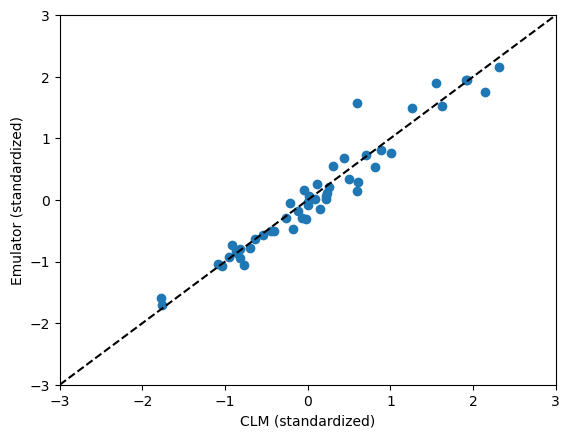

In [41]:
plt.scatter(y_test, y_pred)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.plot([-3,3],[-3,3],c='k',linestyle='--',label='1:1 line')
plt.xlabel('CLM (standardized)',fontsize = 10)
plt.ylabel('Emulator (standardized)',fontsize = 10);

In [42]:
# try testing 10 values
test_ten = params[:10]
test_ten.shape

(10, 32)

In [44]:
test_pred, test_var = emulator.predict_f(test_ten.values)

In [45]:
test_pred.shape

TensorShape([10, 1])

In [50]:
# try one set
test_one = params[:1]
test_one.shape

(1, 32)

In [52]:
test_pred, test_var = emulator.predict_f(test_one.values)

In [53]:
test_pred.shape

TensorShape([1, 1])

### Linnia's original code/plots

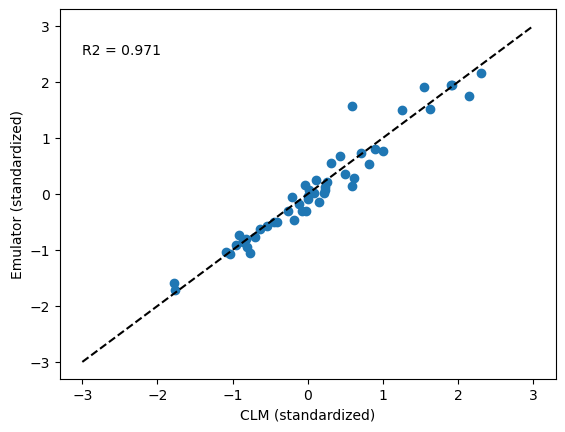

In [16]:
ntest = 50
data = NL_LAI_PPE[1:]

Y = standardize(data)

# split training and testing data
X_test, X_train = params[:ntest], params[ntest:]
y_test, y_train = Y[:ntest], Y[ntest:]

# define emulator model and train
emulator = gpflow.models.GPR(data=(X_train, y_train), kernel=kernel, mean_function=None)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(emulator.training_loss, emulator.trainable_variables, options=dict(maxiter=100))

y_pred, y_var = emulator.predict_f(X_test.values)

# plot validation
ax = plt.subplot(1,1,1)
plot_validation(y_test, np.array(y_pred), ax)

### Sample and Predict

In [17]:
### Take a random sample from parameter space and use emulator to estimate LAI
#randomly sample parameters
n_samp = 1000
sample = get_random_params(nparams, n_samp)

In [18]:
y_pred, y_pred_var = emulator.predict_f(sample) 

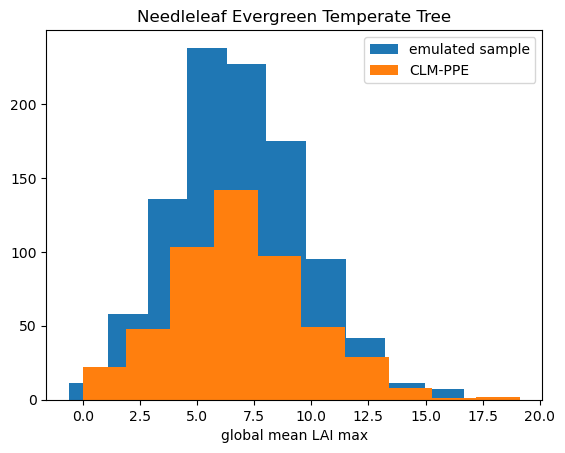

In [19]:
# unstandardize and plot
NL_LAI_pred = unstandardize(np.array(y_pred).reshape(1,-1),NL_LAI_PPE)
plt.hist(NL_LAI_pred.flatten(),label='emulated sample')
plt.hist(NL_LAI_PPE,label='CLM-PPE')
plt.xlabel('global mean LAI max')
plt.title('Needleleaf Evergreen Temperate Tree')
plt.legend()